In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Install required packages
!pip install albumentations==1.4.18 grad-cam==1.4.8 torch==2.4.1 torchvision==0.19.1 -q

import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import copy
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 3.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 88.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 76.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.5 MB/s eta 0

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# **1. Configuration**

In [3]:
class CFG:
    data_dir = '/kaggle/input/human-bone-fractures-image-dataset/Human Bone Fractures Multi-modal Image Dataset (HBFMID)/Bone Fractures Detection'
    model_save_path = '/kaggle/working/best_attention_fracture_model.pth'
    batch_size = 16  # Reduced for Kaggle's memory constraints
    img_size = 224
    epochs = 20  # Reduced for faster experimentation
    patience = 5  # Early stopping
    num_workers = 0  # Set to 0 for Kaggle stability (multiprocessing can be flaky)
    lr = 1e-4
    seed = 42

# Set random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG.seed)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# **2. Data Utilities**

Classes: ['Comminuted', 'Greenstick', 'Healthy', 'Linear', 'Oblique Displaced', 'Oblique', 'Segmental', 'Spiral', 'Transverse Displaced', 'Transverse']
Train images: 1344, Val images: 128, Test images: 64


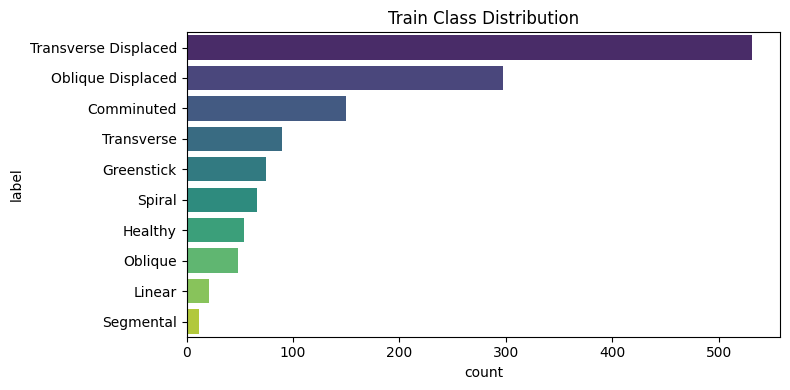

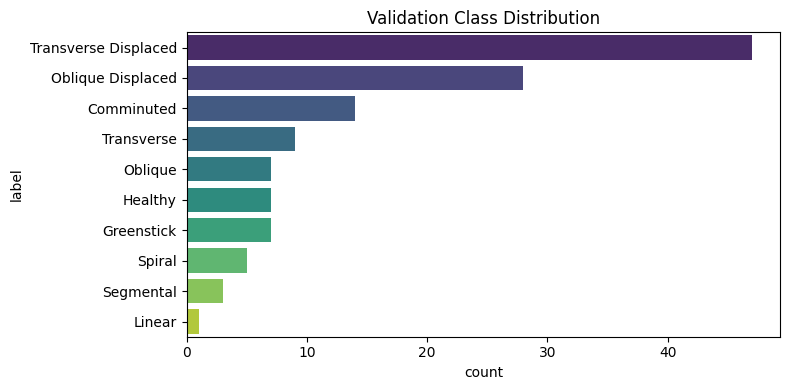

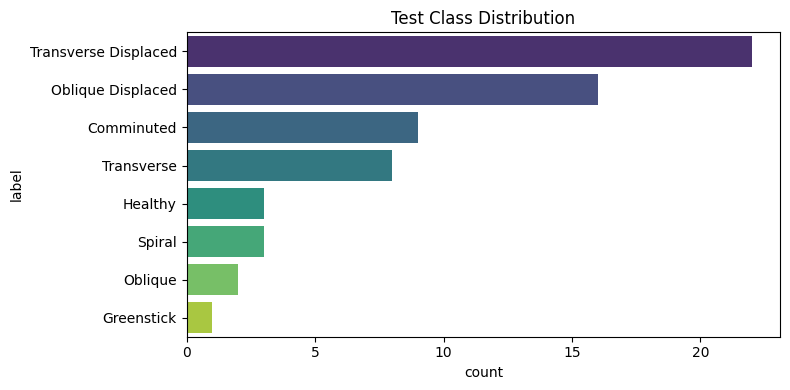

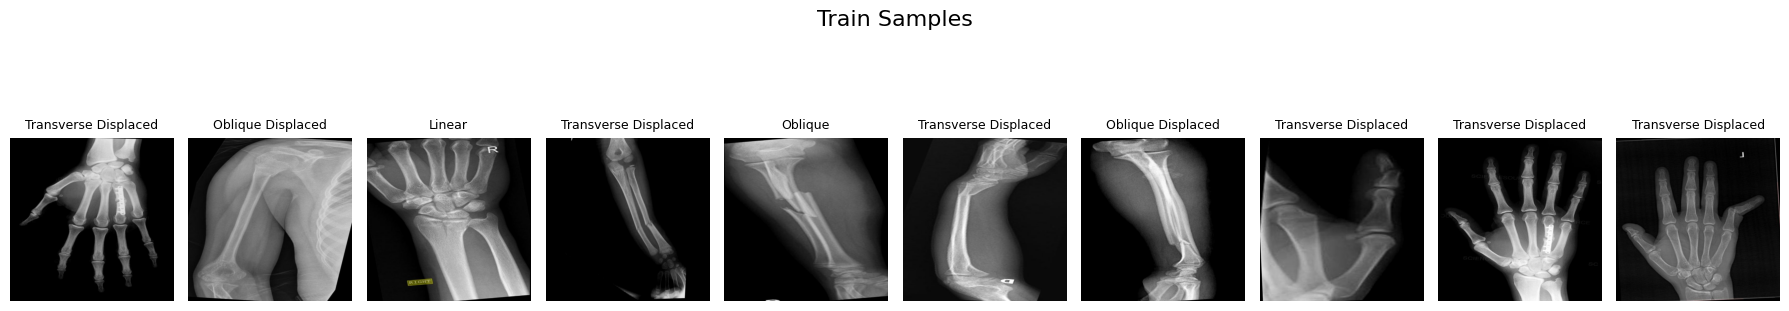

In [4]:
# Parse class names
YAML_PATH = os.path.join(CFG.data_dir, 'data.yaml')
if os.path.exists(YAML_PATH):
    with open(YAML_PATH, 'r') as f:
        data_yaml = yaml.safe_load(f)
    CLASSES = data_yaml.get('names', [])
else:
    print("Warning: data.yaml not found, using default classes")
    CLASSES = ['elbow', 'finger', 'forearm', 'humerus', 'shoulder', 'femur', 'shinbone', 'knee', 'hipbone', 'wrist', 'healthy']
NUM_CLASSES = len(CLASSES)
print(f"Classes: {CLASSES}")

# Load dataset
def load_data(split='train'):
    img_dir = os.path.join(CFG.data_dir, split, 'images')
    label_dir = os.path.join(CFG.data_dir, split, 'labels')
    images, labels = [], []
    if not os.path.exists(img_dir) or not os.path.exists(label_dir):
        print(f"Error: Directory {img_dir} or {label_dir} does not exist")
        return images, labels
    for img_file in os.listdir(img_dir):
        if img_file.lower().endswith(('.jpg', '.png')):
            img_path = os.path.join(img_dir, img_file)
            label_path = os.path.join(label_dir, img_file.rsplit('.', 1)[0] + '.txt')
            if os.path.exists(label_path):
                try:
                    with open(label_path, 'r') as lf:
                        label_lines = lf.readlines()
                        if label_lines:
                            class_id = int(label_lines[0].split()[0])
                            if 0 <= class_id < NUM_CLASSES:
                                images.append(img_path)
                                labels.append(class_id)
                            else:
                                print(f"Warning: Invalid class ID {class_id} in {label_path}")
                except Exception as e:
                    print(f"Error reading {label_path}: {e}")
    return images, labels

train_images, train_labels = load_data('train')
val_images, val_labels = load_data('valid')
test_images, test_labels = load_data('test')

print(f"Train images: {len(train_images)}, Val images: {len(val_images)}, Test images: {len(test_images)}")

# Check if datasets are empty
if not train_images or not val_images or not test_images:
    raise ValueError("One or more datasets are empty. Please check the data directory and files.")

# Visualize class distribution
def plot_class_distribution(labels, split_name):
    df = pd.DataFrame({'label': [CLASSES[l] for l in labels]})
    plt.figure(figsize=(8, 4))
    sns.countplot(y='label', data=df, order=pd.value_counts(df['label']).index, palette='viridis')
    plt.title(f'{split_name} Class Distribution')
    plt.tight_layout()
    plt.show()
    plt.close()

plot_class_distribution(train_labels, "Train")
plot_class_distribution(val_labels, "Validation")
plot_class_distribution(test_labels, "Test")

# Show sample images
def show_samples(images, labels, n=10, title="Sample Images"):
    plt.figure(figsize=(18, 4))
    idxs = np.random.choice(len(images), min(n, len(images)), replace=False)
    for i, idx in enumerate(idxs):
        img = Image.open(images[idx])
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(CLASSES[labels[idx]], fontsize=9)
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.close()

if train_images:
    show_samples(train_images, train_labels, n=10, title="Train Samples")

# **3. Dataset and Augmentation**

In [5]:
class FractureDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        try:
            img = np.array(Image.open(img_path).convert('RGB'))
            if self.transform:
                img = self.transform(image=img)['image']
            return img, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

train_transform = A.Compose([
    A.Resize(CFG.img_size, CFG.img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=5, p=0.5),  # [-5, +5] degrees
    A.Affine(shear=(-2, 2), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(CFG.img_size, CFG.img_size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_ds = FractureDataset(train_images, train_labels, train_transform)
val_ds = FractureDataset(val_images, val_labels, val_test_transform)
test_ds = FractureDataset(test_images, test_labels, val_test_transform)

# Filter out None entries from dataset
train_ds = [(img, lbl) for img, lbl in train_ds if img is not None]
val_ds = [(img, lbl) for img, lbl in val_ds if img is not None]
test_ds = [(img, lbl) for img, lbl in test_ds if img is not None]

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

# **4. CBAM Attention Module**

In [6]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv1(x_cat)
        return self.sigmoid(x_out)

class CBAM(nn.Module):
    def __init__(self, channels, ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(channels, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

# **5. Model**

In [7]:
class AttentionModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet50(weights='IMAGENET1K_V1')
        self.backbone.fc = nn.Identity()
        self.cbam = CBAM(2048)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        feats = self.backbone(x)  # shape: [B, 2048, 1, 1]
        feats = feats.view(feats.size(0), 2048, 1, 1)
        attended = self.cbam(feats)
        pooled = self.pool(attended).view(attended.size(0), -1)
        out = self.fc(pooled)
        return out

# **6. Training Utilities**

In [8]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct = 0, 0
    total_samples = 0
    for imgs, labels in tqdm(loader, leave=False):
        if imgs is None or labels is None:
            continue
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += imgs.size(0)
    avg_loss = running_loss / total_samples if total_samples > 0 else float('inf')
    avg_acc = correct / total_samples if total_samples > 0 else 0
    return avg_loss, avg_acc

def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct = 0, 0
    total_samples = 0
    with torch.no_grad():
        for imgs, labels in loader:
            if imgs is None or labels is None:
                continue
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += imgs.size(0)
    avg_loss = running_loss / total_samples if total_samples > 0 else float('inf')
    avg_acc = correct / total_samples if total_samples > 0 else 0
    return avg_loss, avg_acc

# **7. Training Loop**

In [9]:
model = AttentionModel(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=1e-4)

train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_counter = 0

for epoch in range(CFG.epochs):
    print(f"Epoch {epoch + 1}/{CFG.epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping and model checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
        torch.save(model.state_dict(), CFG.model_save_path)
        print(f"  Model saved to {CFG.model_save_path}!")
    else:
        early_stop_counter += 1
        print(f"  Early stopping counter: {early_stop_counter}/{CFG.patience}")
        if early_stop_counter >= CFG.patience:
            print("  Early stopping triggered!")
            break

# Load best model weights
model.load_state_dict(best_model_wts)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s] 


Epoch 1/20


  Train Loss: 1.5701, Acc: 0.5275 | Val Loss: 1.3057, Acc: 0.5078
  Model saved to /kaggle/working/best_attention_fracture_model.pth!
Epoch 2/20


  Train Loss: 0.7574, Acc: 0.7731 | Val Loss: 0.7644, Acc: 0.7266
  Model saved to /kaggle/working/best_attention_fracture_model.pth!
Epoch 3/20


  Train Loss: 0.3512, Acc: 0.9070 | Val Loss: 0.5310, Acc: 0.8984
  Model saved to /kaggle/working/best_attention_fracture_model.pth!
Epoch 4/20


  Train Loss: 0.2328, Acc: 0.9338 | Val Loss: 0.7084, Acc: 0.7344
  Early stopping counter: 1/5
Epoch 5/20


  Train Loss: 0.2052, Acc: 0.9449 | Val Loss: 0.5760, Acc: 0.8672
  Early stopping counter: 2/5
Epoch 6/20


  Train Loss: 0.1114, Acc: 0.9732 | Val Loss: 0.4622, Acc: 0.8516
  Model saved to /kaggle/working/best_attention_fracture_model.pth!
Epoch 7/20


  Train Loss: 0.0888, Acc: 0.9784 | Val Loss: 0.4698, Acc: 0.8672
  Early stopping counter: 1/5
Epoch 8/20


  Train Loss: 0.0636, Acc: 0.9821 | Val Loss: 0.5091, Acc: 0.8672
  Early stopping counter: 2/5
Epoch 9/20


  Train Loss: 0.0863, Acc: 0.9807 | Val Loss: 0.3513, Acc: 0.8984
  Model saved to /kaggle/working/best_attention_fracture_model.pth!
Epoch 10/20


  Train Loss: 0.0874, Acc: 0.9807 | Val Loss: 0.4147, Acc: 0.8750
  Early stopping counter: 1/5
Epoch 11/20


  Train Loss: 0.0537, Acc: 0.9874 | Val Loss: 0.4084, Acc: 0.9062
  Early stopping counter: 2/5
Epoch 12/20


  Train Loss: 0.0407, Acc: 0.9888 | Val Loss: 0.3137, Acc: 0.9141
  Model saved to /kaggle/working/best_attention_fracture_model.pth!
Epoch 13/20


  Train Loss: 0.0402, Acc: 0.9918 | Val Loss: 0.4796, Acc: 0.8438
  Early stopping counter: 1/5
Epoch 14/20


  Train Loss: 0.0550, Acc: 0.9844 | Val Loss: 0.6214, Acc: 0.8516
  Early stopping counter: 2/5
Epoch 15/20


  Train Loss: 0.1005, Acc: 0.9673 | Val Loss: 0.8315, Acc: 0.7734
  Early stopping counter: 3/5
Epoch 16/20


  Train Loss: 0.0587, Acc: 0.9844 | Val Loss: 0.4609, Acc: 0.8594
  Early stopping counter: 4/5
Epoch 17/20


  Train Loss: 0.0291, Acc: 0.9948 | Val Loss: 0.3763, Acc: 0.8672
  Early stopping counter: 5/5
  Early stopping triggered!


<All keys matched successfully>

# **8. Training Curves**

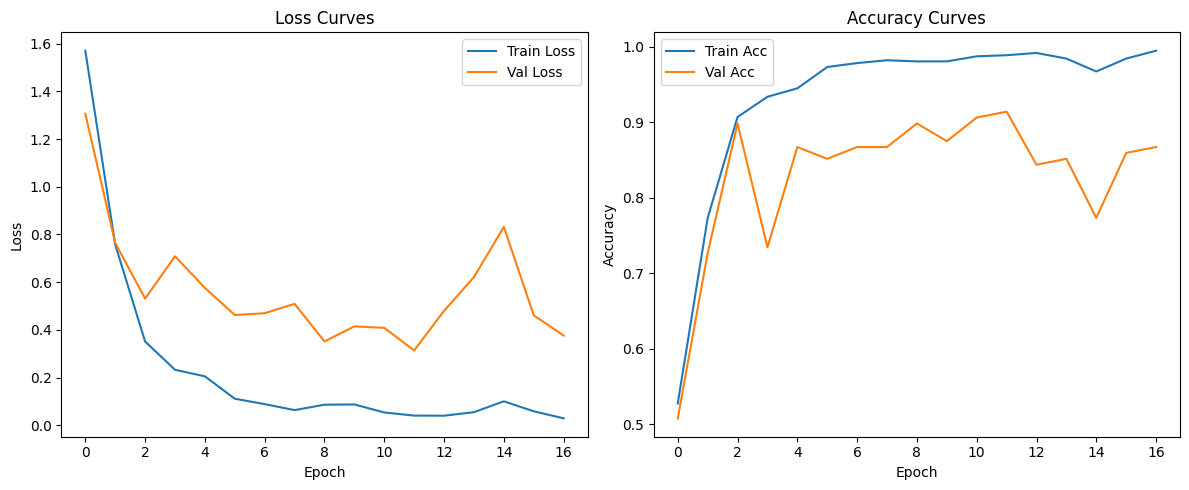

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# **9. Test Evaluation**

                      precision    recall  f1-score   support

          Comminuted       0.88      0.78      0.82         9
          Greenstick       1.00      1.00      1.00         1
             Healthy       0.75      1.00      0.86         3
              Linear       0.00      0.00      0.00         0
   Oblique Displaced       0.93      0.81      0.87        16
             Oblique       1.00      0.50      0.67         2
           Segmental       0.00      0.00      0.00         0
              Spiral       0.60      1.00      0.75         3
Transverse Displaced       0.91      0.95      0.93        22
          Transverse       1.00      1.00      1.00         8

           micro avg       0.89      0.89      0.89        64
           macro avg       0.71      0.70      0.69        64
        weighted avg       0.90      0.89      0.89        64



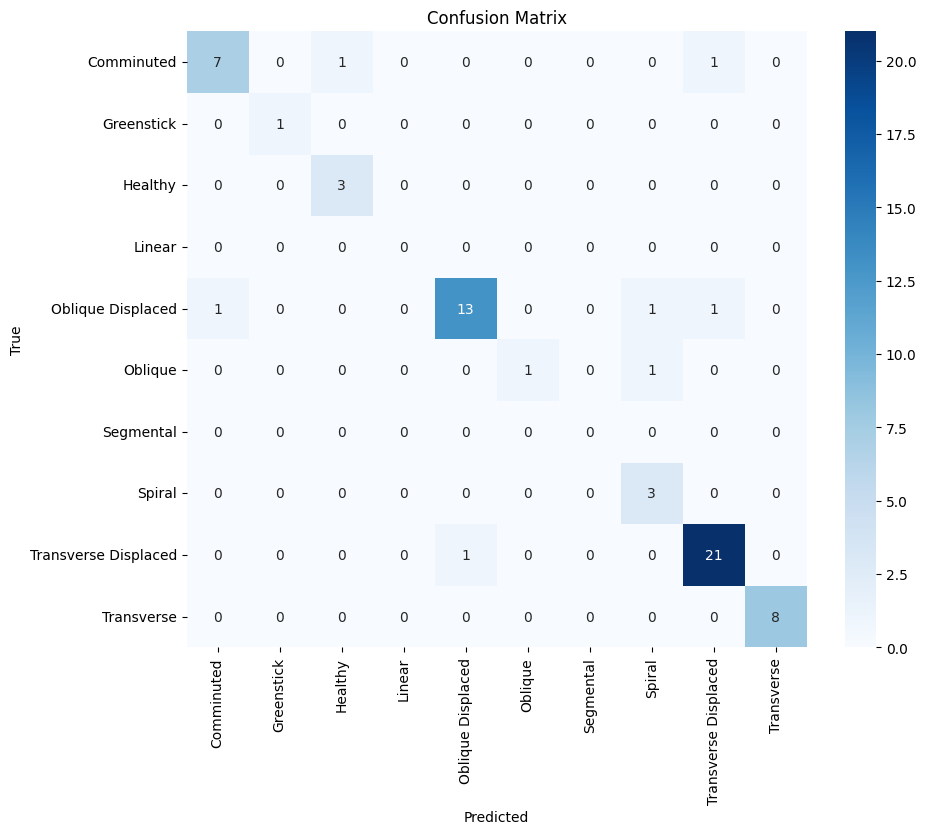

ROC AUC score is not defined for some classes: Only one class present in y_true. ROC AUC score is not defined in that case.


In [14]:
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize

model.eval()
test_preds, test_true, test_probs = [], [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        if imgs is None or labels is None:
            continue
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = nn.Softmax(dim=1)(outputs)
        test_preds.extend(outputs.argmax(1).cpu().numpy())
        test_true.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

if len(test_true) > 0:
    print(classification_report(
        test_true, test_preds,
        labels=list(range(len(CLASSES))),
        target_names=CLASSES,
        zero_division=0
    ))

    # Confusion Matrix
    cm = confusion_matrix(test_true, test_preds, labels=list(range(len(CLASSES))))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    plt.close()

    # Robust ROC AUC calculation
    unique_labels = np.unique(test_true)
    if len(unique_labels) > 1:
        test_true_bin = label_binarize(test_true, classes=list(range(len(CLASSES))))
        test_probs_arr = np.array(test_probs)
        if test_probs_arr.shape[1] != len(CLASSES):
            pad_width = len(CLASSES) - test_probs_arr.shape[1]
            test_probs_arr = np.pad(test_probs_arr, ((0,0), (0,pad_width)), mode='constant')
        try:
            roc_auc = roc_auc_score(test_true_bin, test_probs_arr, average='macro')
            print(f'Macro ROC AUC: {roc_auc:.4f}')
        except ValueError as e:
            print(f"ROC AUC score is not defined for some classes: {e}")
    else:
        print("ROC AUC score is not defined: only one class present in test labels.")
else:
    print("No test data available for evaluation")